### Configuration Parameters

In [1]:
# Configuration Parameters
CONFIG = {
    "layers_list": [5, 10, 20, 30, 40, 50],
    "init_types": [
        "he_normal", "he_uniform",
        "xavier_normal", "xavier_uniform",
        "normal", "zero",
        "orthogonal", "trunc_normal"
    ],
    "activations": ["relu", "tanh", "sigmoid", "gelu"],
    "init_params": {
        "he_normal":   {"factor": 2.0, "mode": "fan_in", "nonlinearity": "relu"},
        "he_uniform":  {"factor": 2.0, "mode": "fan_in", "nonlinearity": "relu"},
        "orthogonal":  {"gain": 1.0},
        "trunc_normal": {"mean": 0.0, "std": 0.01, "a": -2.0, "b": 2.0}
    },
    "hidden_size": 128,
    "input_size": 784,
    "output_size": 10,
    "num_epochs": 50,
    "lr": 0.01,
    "batch_size": 128,
    "save_dir": "results"
}

### Environment Setup

In [2]:
# Environment Setup
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import math
import os
import time
from typing import Dict
import random
import matplotlib.pyplot as plt

def set_seed(seed=42):  # Set random seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

### Create result output directory

In [3]:
# Create result output directory
def make_plot_dir():
    os.makedirs(CONFIG["save_dir"], exist_ok=True)

# Activation function selector
def get_activation(name: str):
    if name == "relu":    return F.relu
    if name == "tanh":    return torch.tanh
    if name == "sigmoid": return torch.sigmoid
    if name == "gelu":    return F.gelu
    raise ValueError(f"Unsupported activation: {name}")

# Model definition
class DeepMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers, activation):
        super().__init__()
        self.activation_fn = get_activation(activation)
        self.hidden = nn.ModuleList([
            nn.Linear(input_size if i == 0 else hidden_size, hidden_size)
            for i in range(num_hidden_layers)
        ])
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        for layer in self.hidden:
            x = self.activation_fn(layer(x))
        return self.output(x)

# Weight initialization
def initialize_weights(model: nn.Module, init_type: str, params: Dict = None):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            p = params or {}
            if init_type == 'he_normal':
                fan = nn.init._calculate_correct_fan(m.weight, p.get('mode','fan_in'))
                std = math.sqrt(p.get('factor',2.0) / fan)
                nn.init.normal_(m.weight, 0.0, std)
            elif init_type == 'he_uniform':
                fan = nn.init._calculate_correct_fan(m.weight, p.get('mode','fan_in'))
                bound = math.sqrt(3.0 * p.get('factor',2.0) / fan)
                nn.init.uniform_(m.weight, -bound, bound)
            elif init_type == 'xavier_normal': nn.init.xavier_normal_(m.weight)
            elif init_type == 'xavier_uniform': nn.init.xavier_uniform_(m.weight)
            elif init_type == 'normal': nn.init.normal_(m.weight, p.get('mean',0.0), p.get('std',0.1))
            elif init_type == 'zero': nn.init.constant_(m.weight, 0.0)
            elif init_type == 'orthogonal': nn.init.orthogonal_(m.weight, p.get('gain',1.0))
            elif init_type == 'trunc_normal':
                nn.init.trunc_normal_(m.weight, p.get('mean',0.0), p.get('std',0.1), p.get('a',-2.0), p.get('b',2.0))
            else:
                raise ValueError(f"Unknown init type: {init_type}")
            nn.init.constant_(m.bias, 0.0)

# Data loading
def get_dataloaders(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))
    ])
    train_dataset = datasets.MNIST('./data', True, download=True, transform=transform)
    test_dataset  = datasets.MNIST('./data', False, download=True, transform=transform)
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training step
def train(model, optimizer, criterion, loader, device):
    model.train()
    total_loss, correct = 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        correct += (output.argmax(1) == y).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

# Evaluation step
def evaluate(model, criterion, loader, device):
    model.eval()
    total_loss, correct = 0.0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
            total_loss += loss.item() * x.size(0)
            correct += (output.argmax(1) == y).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

# Experiment execution (includes activation & gradient hooks + stats saving)
def run_experiment(init_type: str, num_layers: int, activation: str, config: Dict):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_loader, test_loader = get_dataloaders(config['batch_size'])
    model = DeepMLP(config['input_size'], config['hidden_size'], config['output_size'], num_layers, activation).to(device)

    # Hook containers
    layer_acts = [[] for _ in model.hidden]
    layer_grads = [[] for _ in model.hidden]

    # Hook factory functions
    def make_forward_hook(idx):
        def forward_hook(module, inp, out):
            layer_acts[idx].append(out.detach().cpu().numpy())
        return forward_hook
    def make_backward_hook(idx):
        def backward_hook(module, grad_in, grad_out):
            layer_grads[idx].append(grad_out[0].detach().cpu().numpy())
        return backward_hook

    # Register hooks
    for idx, layer in enumerate(model.hidden):
        layer.register_forward_hook(make_forward_hook(idx))
        layer.register_full_backward_hook(make_backward_hook(idx))

    # Initialize weights
    init_params = config.get('init_params', {}).get(init_type, {})
    initialize_weights(model, init_type, init_params)
    optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'])
    criterion = nn.CrossEntropyLoss()

    # Build training history dict (with basic and per-layer stats)
    history = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': [], 'epoch_time': []}
    for i in range(num_layers):
        history[f'act_mean_{i}'] = []
        history[f'act_std_{i}'] = []
        history[f'grad_norm_{i}'] = []

    prefix = f"{init_type}_{activation}_{num_layers}L"

    # Epoch loop
    for ep in range(1, config['num_epochs'] + 1):
        # Clear caches
        for lst in layer_acts: lst.clear()
        for lst in layer_grads: lst.clear()

        start = time.time()
        tl, ta = train(model, optimizer, criterion, train_loader, device)
        vl, va = evaluate(model, criterion, test_loader, device)
        duration = time.time() - start

        # Record basic metrics
        history['train_loss'].append(tl)
        history['test_loss'].append(vl)
        history['train_acc'].append(ta)
        history['test_acc'].append(va)
        history['epoch_time'].append(duration)

        # Record per-layer stats
        for i, layer in enumerate(model.hidden):
            acts_arr = np.concatenate([a.reshape(-1) for a in layer_acts[i]]) if layer_acts[i] else np.array([])
            history[f'act_mean_{i}'].append(acts_arr.mean() if acts_arr.size else np.nan)
            history[f'act_std_{i}'].append(acts_arr.std() if acts_arr.size else np.nan)
            grads_arr = np.concatenate([g.reshape(-1) for g in layer_grads[i]]) if layer_grads[i] else np.array([])
            history[f'grad_norm_{i}'].append(np.linalg.norm(grads_arr))

        print(f"[{init_type}|{activation}|{num_layers}L] "
              f"Ep{ep}/{config['num_epochs']} "
              f"TL={tl:.4f} TA={ta:.4f} VL={vl:.4f} VA={va:.4f} T={duration:.2f}s")

    # Save to CSV
    df = pd.DataFrame(history)
    os.makedirs(config['save_dir'], exist_ok=True)
    df.to_csv(os.path.join(config['save_dir'], f"{prefix}.csv"), index=False)
    return history

### Main routine
> ⚠️ **Warning: Full Experiment Time**
>
> Running the complete set of experiments — covering **4 activation functions × 8 initialization strategies × multiple network depths** — may take up to **8 hours** on a GPU.
>
> For quick testing or debugging, please modify the parameters at the top of the notebook

In [ ]:
# Main routine
def main():
    make_plot_dir()
    total_exps = len(CONFIG['init_types']) * len(CONFIG['activations']) * len(CONFIG['layers_list'])
    completed = 0
    overall_start = time.time()

    for init in CONFIG['init_types']:
        for act in CONFIG['activations']:
            for layer_count in CONFIG['layers_list']:
                run_experiment(init, layer_count, act, CONFIG)
                completed += 1
                elapsed = time.time() - overall_start
                avg_per = elapsed / completed
                remaining = avg_per * (total_exps - completed)
                print(f"[{completed}/{total_exps}] Elapsed={time.strftime('%H:%M:%S', time.gmtime(elapsed))} "
                      f"ETA={time.strftime('%H:%M:%S', time.gmtime(remaining))}")

if __name__ == '__main__':
    main()

### Compare different initialization strategies under the same activation function

✅ Saved plot: results/final_acc_vs_layers_relu.png


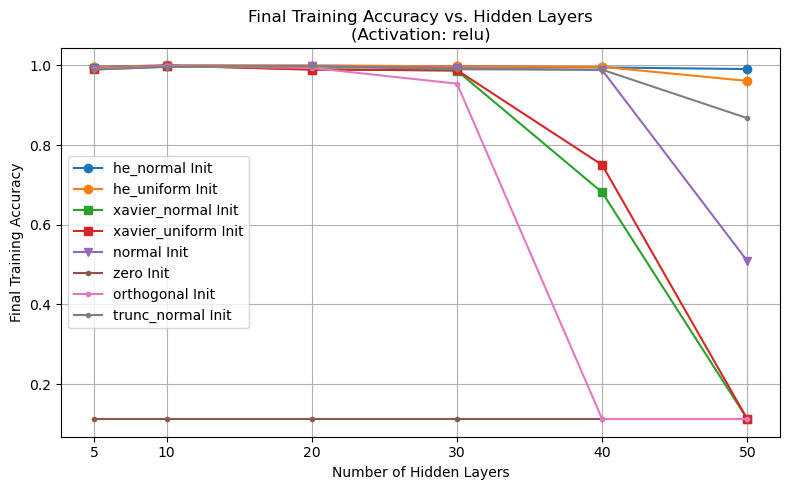

✅ Saved plot: results/epochs_to_peak_relu.png


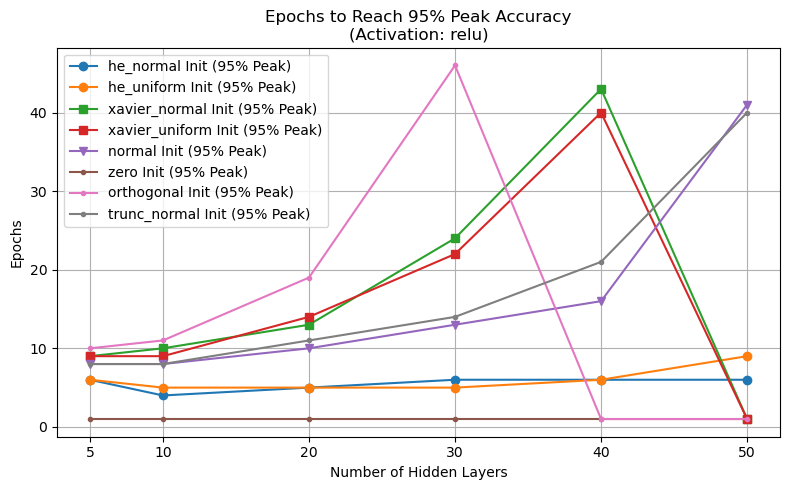

✅ Saved plot: results/final_acc_vs_layers_tanh.png


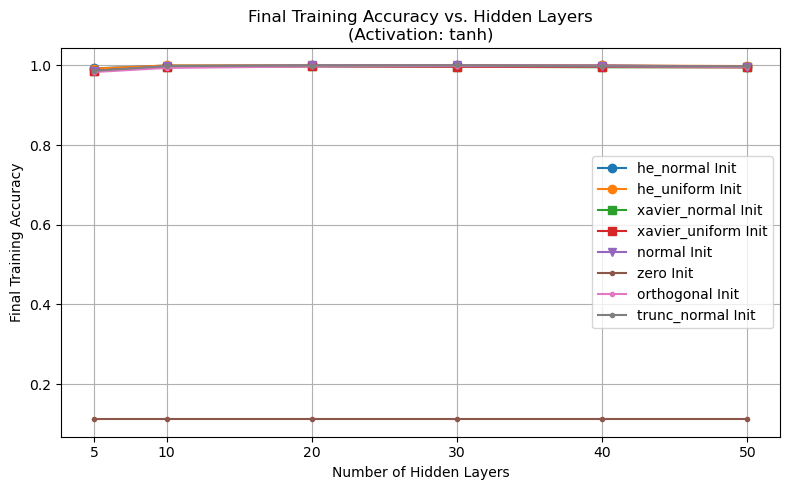

✅ Saved plot: results/epochs_to_peak_tanh.png


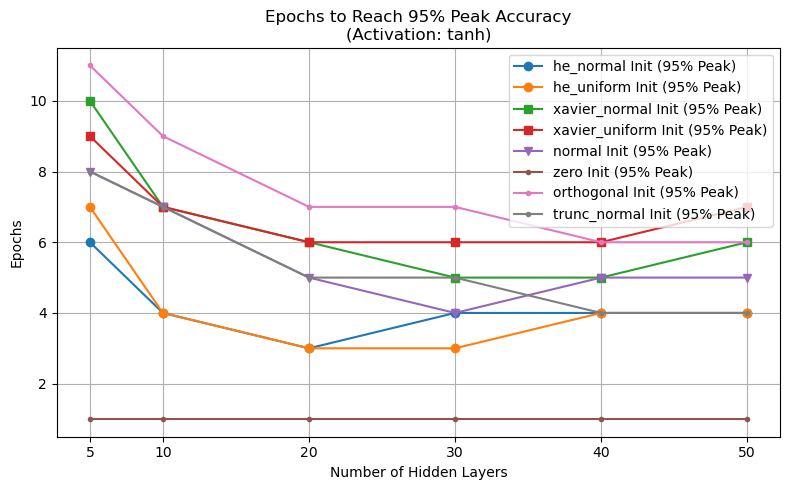

✅ Saved plot: results/final_acc_vs_layers_sigmoid.png


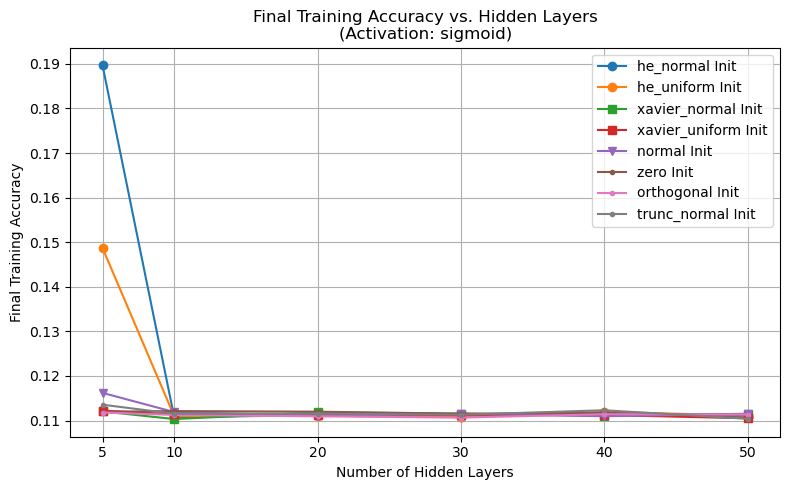

✅ Saved plot: results/epochs_to_peak_sigmoid.png


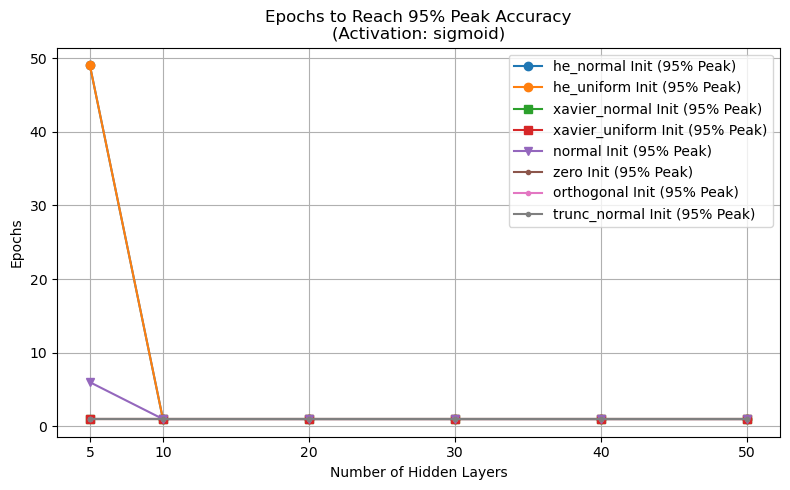

✅ Saved plot: results/final_acc_vs_layers_gelu.png


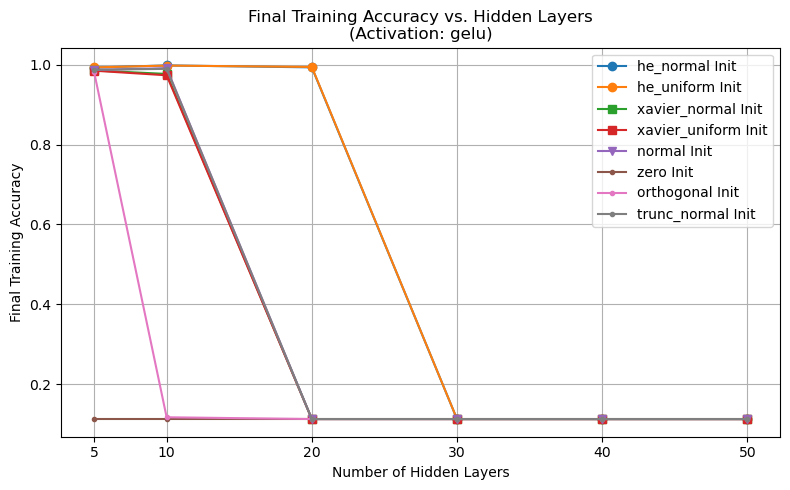

✅ Saved plot: results/epochs_to_peak_gelu.png


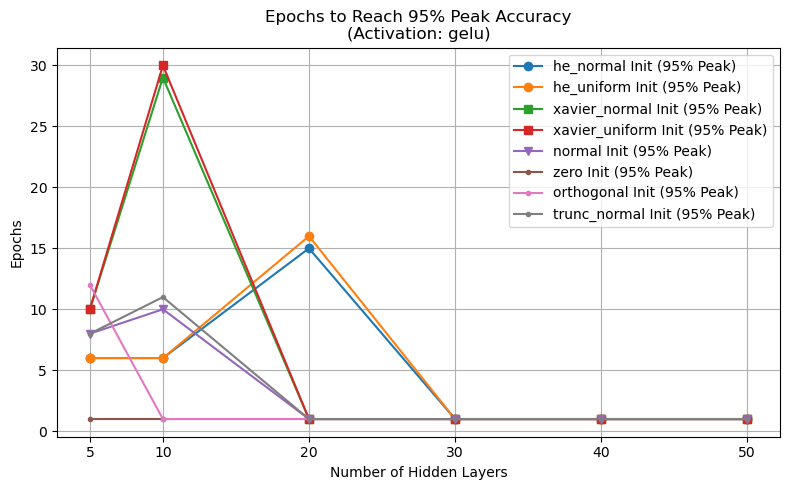

In [4]:
# Compare different initialization strategies under the same activation function
LAYER_LIST = CONFIG["layers_list"]
INIT_TYPES = CONFIG["init_types"]
ACTIVATIONS = CONFIG["activations"]
DATA_DIR = CONFIG["save_dir"]
PERCENT_OF_PEAK = 0.95  # e.g., 0.95 means 95% of the peak accuracy

# Iterate through each activation function
for act in ACTIVATIONS:
    init_acc = {init: [] for init in INIT_TYPES}
    init_peak_epochs = {init: [] for init in INIT_TYPES}
    valid_layers = []

    # Load data for all valid initialization types and layer depths
    for nl in LAYER_LIST:
        all_exist = True
        for init in INIT_TYPES:
            path = f'{DATA_DIR}/{init}_{act}_{nl}L.csv'
            if not os.path.exists(path):
                print(f"⚠️ Missing: {path}")
                all_exist = False
                break
        if not all_exist:
            continue

        valid_layers.append(nl)
        for init in INIT_TYPES:
            df = pd.read_csv(f'{DATA_DIR}/{init}_{act}_{nl}L.csv')
            init_acc[init].append(df['train_acc'].iloc[-1])
            peak = df['train_acc'].max()
            threshold = peak * PERCENT_OF_PEAK
            try:
                epoch = df[df['train_acc'] >= threshold].index[0] + 1
            except IndexError:
                epoch = None
            init_peak_epochs[init].append(epoch)

    # Plot final training accuracy vs number of hidden layers
    plt.figure(figsize=(8, 5))
    for init in INIT_TYPES:
        if len(init_acc[init]) == len(valid_layers):
            marker = {'he': 'o', 'xavier': 's', 'normal': 'v'}.get(init.split('_')[0], '.')
            label = f"{init} Init"
            plt.plot(valid_layers, init_acc[init], marker=marker, label=label)
    plt.title(f'Final Training Accuracy vs. Hidden Layers\n(Activation: {act})')
    plt.xlabel('Number of Hidden Layers')
    plt.ylabel('Final Training Accuracy')
    plt.xticks(valid_layers)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{DATA_DIR}/final_acc_vs_layers_{act}.png")
    print(f"✅ Saved plot: {DATA_DIR}/final_acc_vs_layers_{act}.png")
    plt.show()

    # Plot epochs needed to reach P% of peak accuracy
    plt.figure(figsize=(8, 5))
    for init in INIT_TYPES:
        if len(init_peak_epochs[init]) == len(valid_layers):
            marker = {'he': 'o', 'xavier': 's', 'normal': 'v'}.get(init.split('_')[0], '.')
            label = f"{init} Init ({int(PERCENT_OF_PEAK * 100)}% Peak)"
            plt.plot(valid_layers, init_peak_epochs[init], marker=marker, label=label)
    plt.title(f'Epochs to Reach {int(PERCENT_OF_PEAK * 100)}% Peak Accuracy\n(Activation: {act})')
    plt.xlabel('Number of Hidden Layers')
    plt.ylabel('Epochs')
    plt.xticks(valid_layers)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{DATA_DIR}/epochs_to_peak_{act}.png")
    print(f"✅ Saved plot: {DATA_DIR}/epochs_to_peak_{act}.png")
    plt.show()

### Compare different activation functions under the same initialization strategy

✅ Saved plot: results/acc_vs_layers_he_normal.png


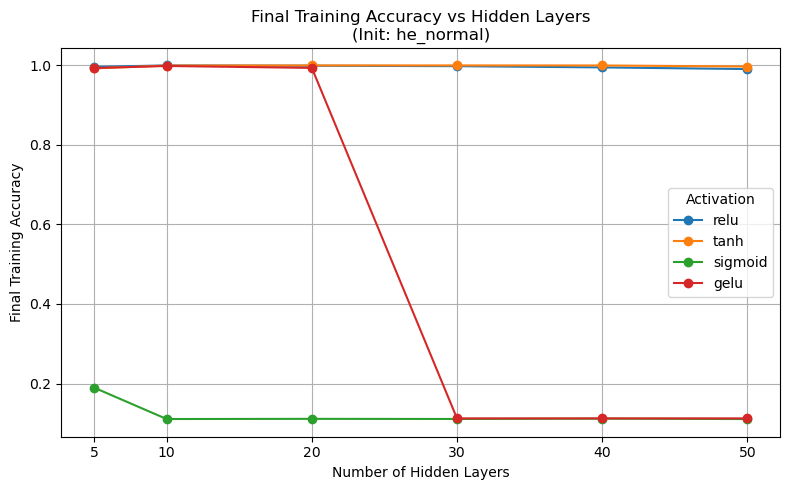

✅ Saved plot: results/epoch_vs_layers_he_normal.png


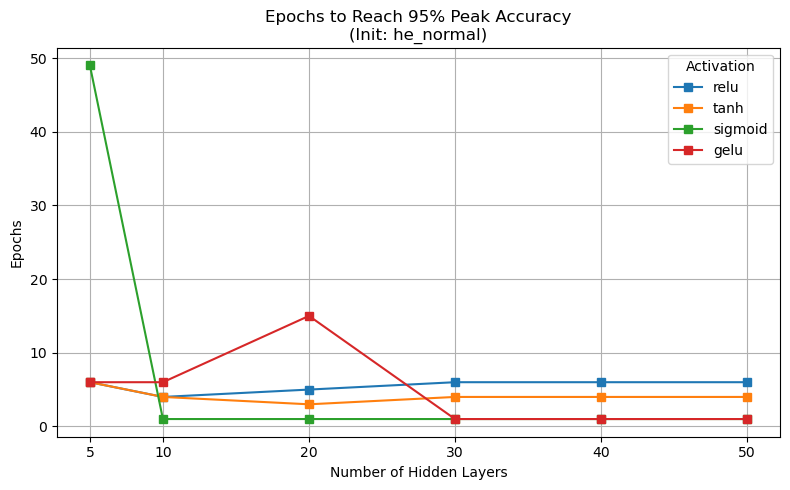

✅ Saved plot: results/acc_vs_layers_he_uniform.png


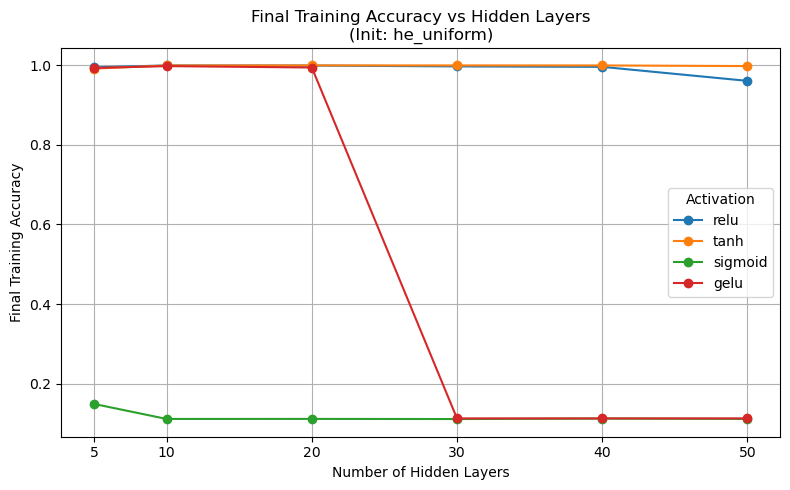

✅ Saved plot: results/epoch_vs_layers_he_uniform.png


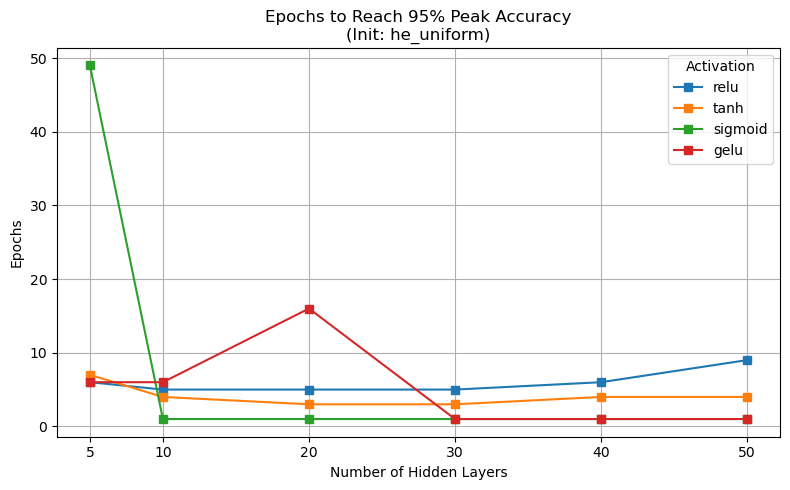

✅ Saved plot: results/acc_vs_layers_xavier_normal.png


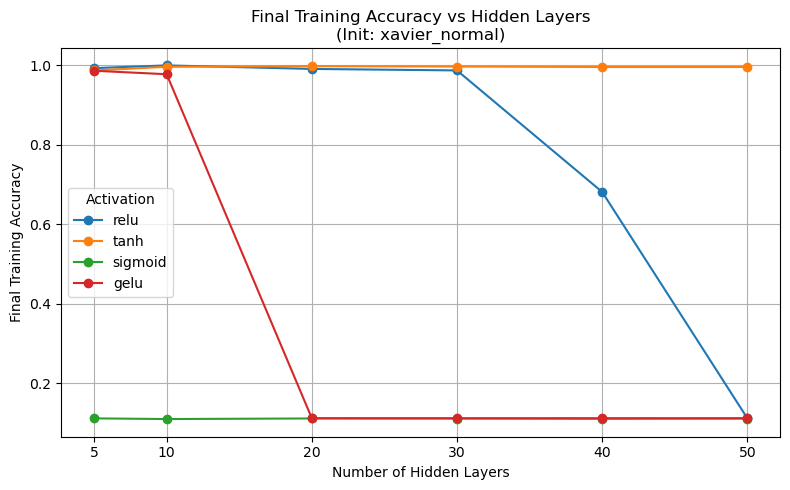

✅ Saved plot: results/epoch_vs_layers_xavier_normal.png


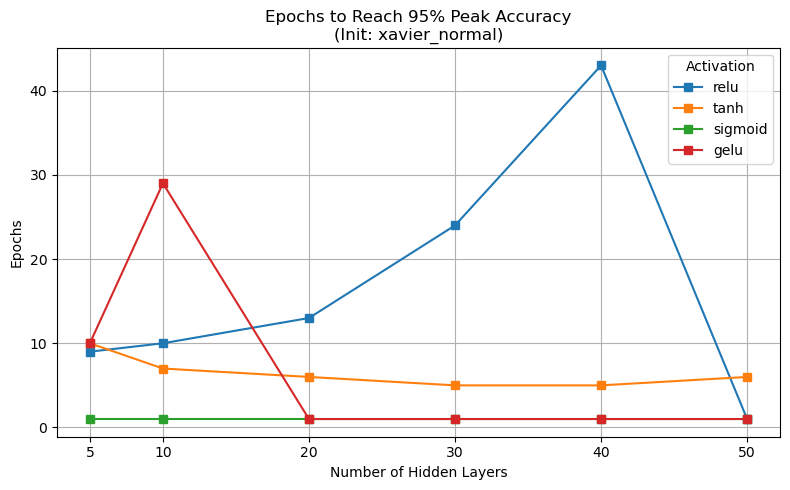

✅ Saved plot: results/acc_vs_layers_xavier_uniform.png


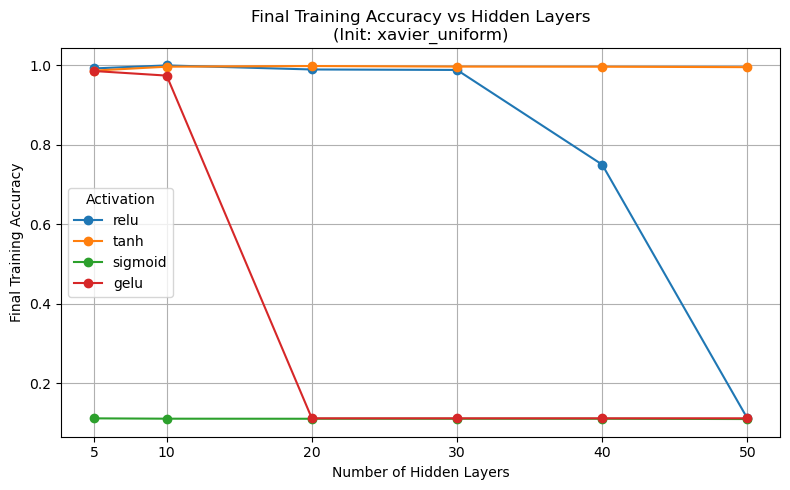

✅ Saved plot: results/epoch_vs_layers_xavier_uniform.png


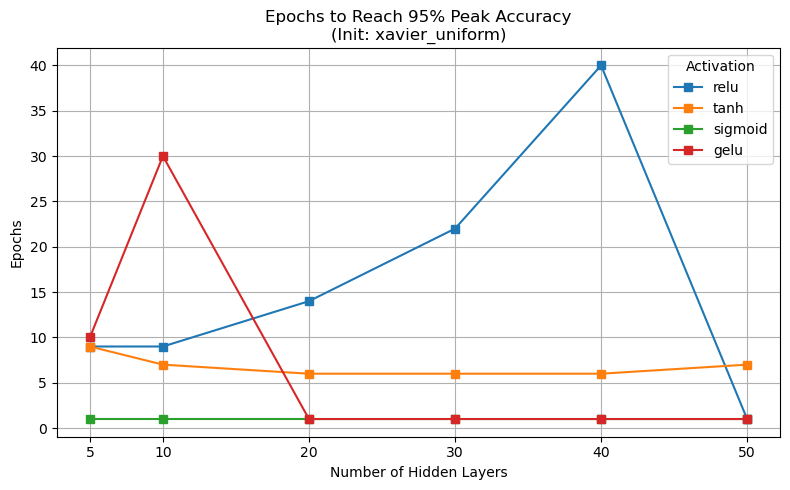

✅ Saved plot: results/acc_vs_layers_normal.png


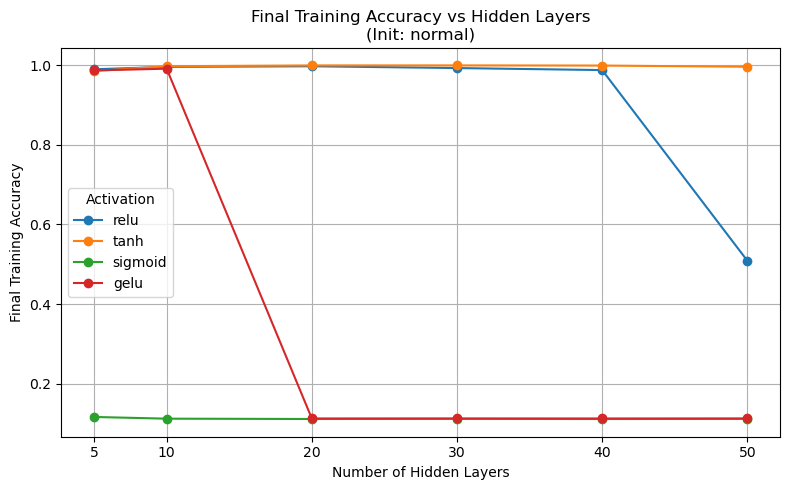

✅ Saved plot: results/epoch_vs_layers_normal.png


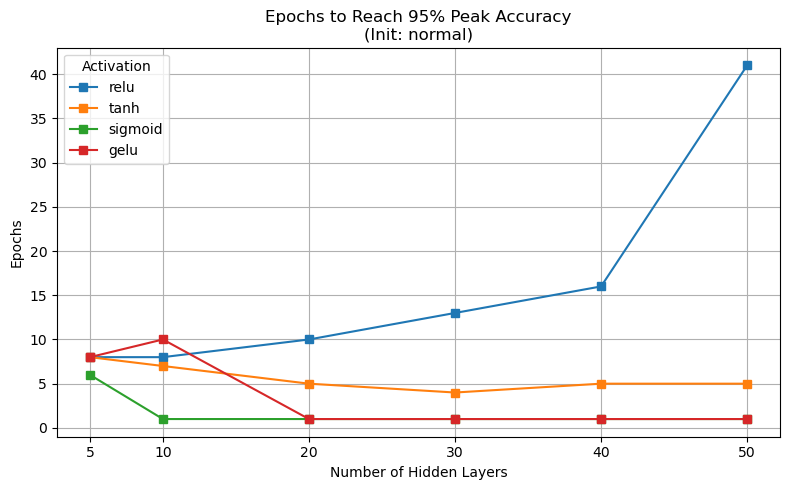

✅ Saved plot: results/acc_vs_layers_zero.png


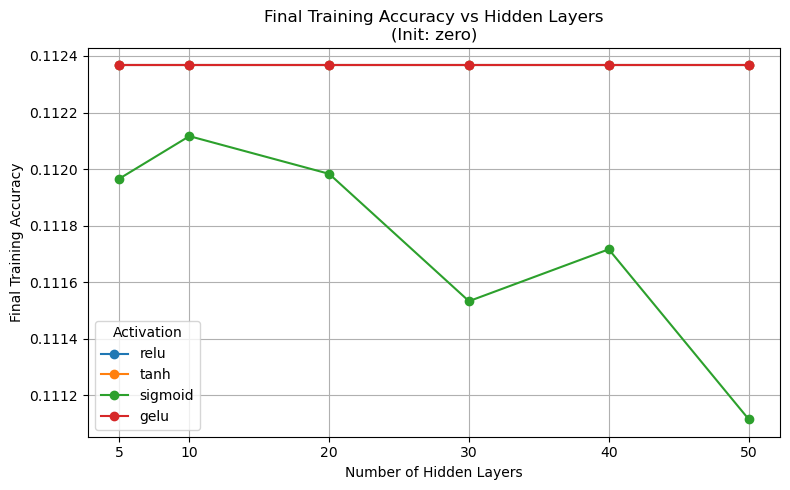

✅ Saved plot: results/epoch_vs_layers_zero.png


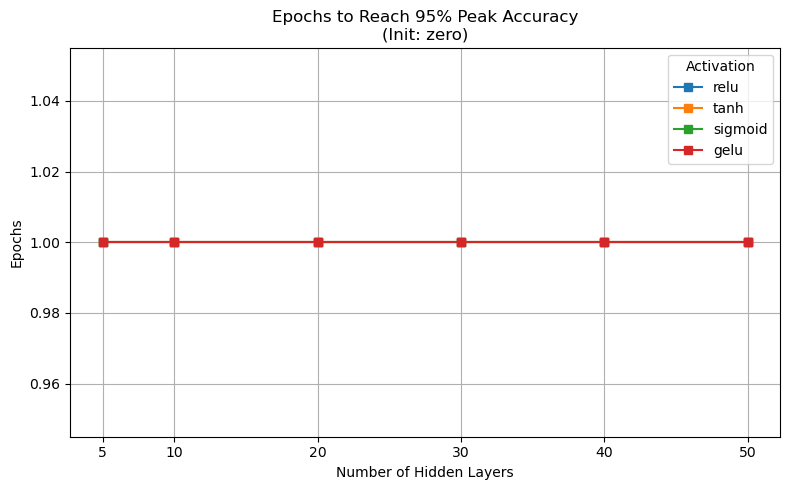

✅ Saved plot: results/acc_vs_layers_orthogonal.png


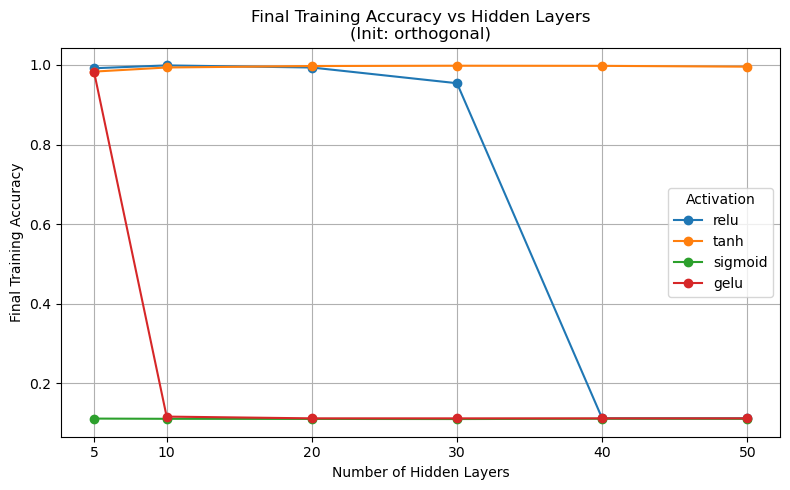

✅ Saved plot: results/epoch_vs_layers_orthogonal.png


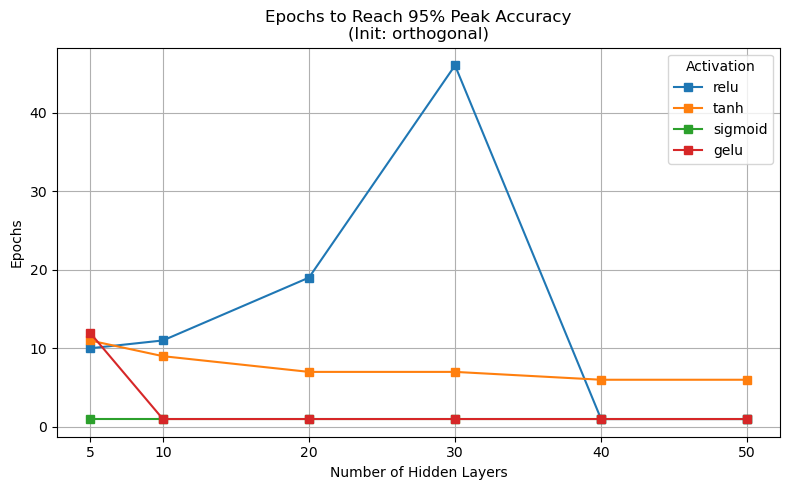

✅ Saved plot: results/acc_vs_layers_trunc_normal.png


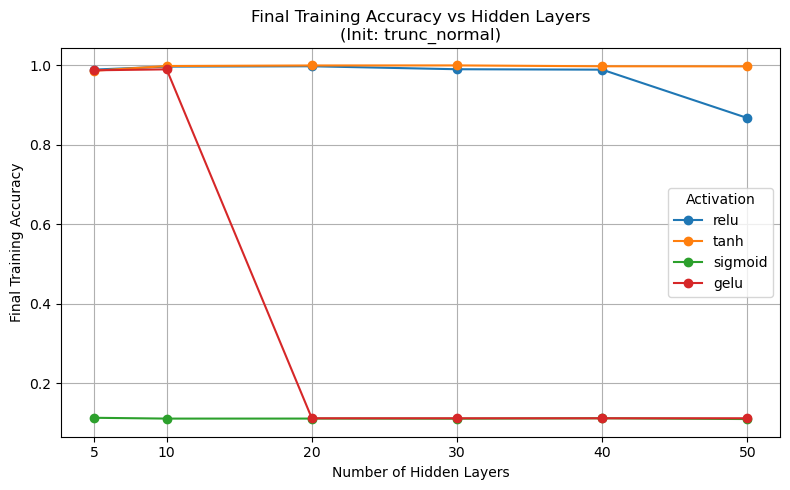

✅ Saved plot: results/epoch_vs_layers_trunc_normal.png


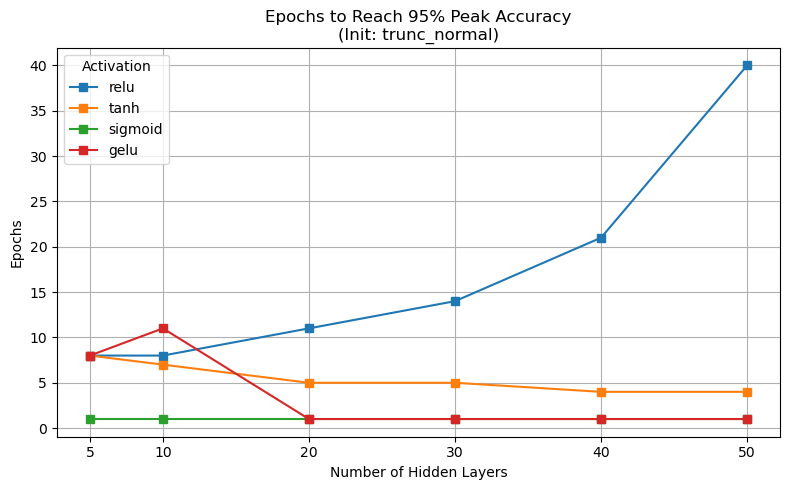

In [5]:
# Compare different activation functions under the same initialization strategy
import pandas as pd
import matplotlib.pyplot as plt
import os

# Automatically read parameters from CONFIG
LAYER_LIST = CONFIG["layers_list"]
INIT_TYPES = CONFIG["init_types"]
ACTIVATIONS = CONFIG["activations"]
DATA_DIR = CONFIG["save_dir"]
PERCENT_OF_PEAK = 0.95  # e.g., 0.95 means 95% of the peak training accuracy

# Iterate through each initialization strategy
for init in INIT_TYPES:
    act_acc = {act: [] for act in ACTIVATIONS}
    act_epochs = {act: [] for act in ACTIVATIONS}
    valid_layers = []

    # Check if all data exists for each activation under current init type
    for nl in LAYER_LIST:
        all_exist = True
        for act in ACTIVATIONS:
            path = f'{DATA_DIR}/{init}_{act}_{nl}L.csv'
            if not os.path.exists(path):
                print(f"⚠️ Missing: {path}")
                all_exist = False
                break
        if not all_exist:
            continue

        valid_layers.append(nl)
        for act in ACTIVATIONS:
            df = pd.read_csv(f'{DATA_DIR}/{init}_{act}_{nl}L.csv')
            act_acc[act].append(df['train_acc'].iloc[-1])
            peak = df['train_acc'].max()
            threshold = peak * PERCENT_OF_PEAK
            try:
                epoch = df[df['train_acc'] >= threshold].index[0] + 1
            except IndexError:
                epoch = None
            act_epochs[act].append(epoch)

    # Plot final training accuracy vs number of hidden layers
    plt.figure(figsize=(8, 5))
    for act in ACTIVATIONS:
        if len(act_acc[act]) == len(valid_layers):
            plt.plot(valid_layers, act_acc[act], marker='o', label=act)
    plt.title(f"Final Training Accuracy vs Hidden Layers\n(Init: {init})")
    plt.xlabel("Number of Hidden Layers")
    plt.ylabel("Final Training Accuracy")
    plt.xticks(valid_layers)
    plt.legend(title="Activation")
    plt.grid(True)
    plt.tight_layout()
    save_path1 = f"{DATA_DIR}/acc_vs_layers_{init}.png"
    plt.savefig(save_path1)
    print(f"✅ Saved plot: {save_path1}")
    plt.show()

    # Plot epochs required to reach X% of peak training accuracy
    plt.figure(figsize=(8, 5))
    for act in ACTIVATIONS:
        if len(act_epochs[act]) == len(valid_layers):
            plt.plot(valid_layers, act_epochs[act], marker='s', label=act)
    plt.title(f"Epochs to Reach {int(PERCENT_OF_PEAK*100)}% Peak Accuracy\n(Init: {init})")
    plt.xlabel("Number of Hidden Layers")
    plt.ylabel("Epochs")
    plt.xticks(valid_layers)
    plt.legend(title="Activation")
    plt.grid(True)
    plt.tight_layout()
    save_path2 = f"{DATA_DIR}/epoch_vs_layers_{init}.png"
    plt.savefig(save_path2)
    print(f"✅ Saved plot: {save_path2}")
    plt.show()

### Activation Mean and Std Visualization

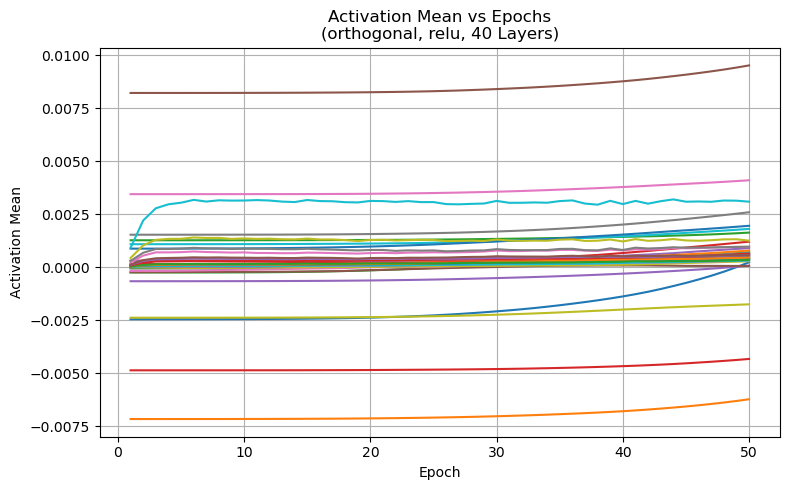

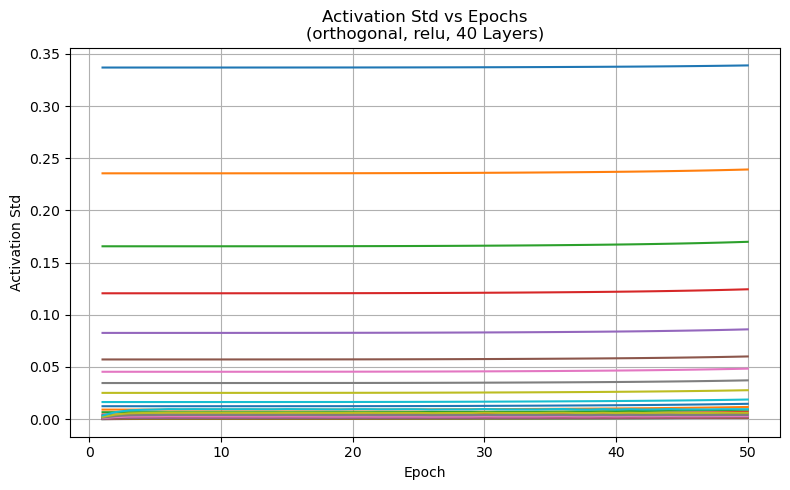

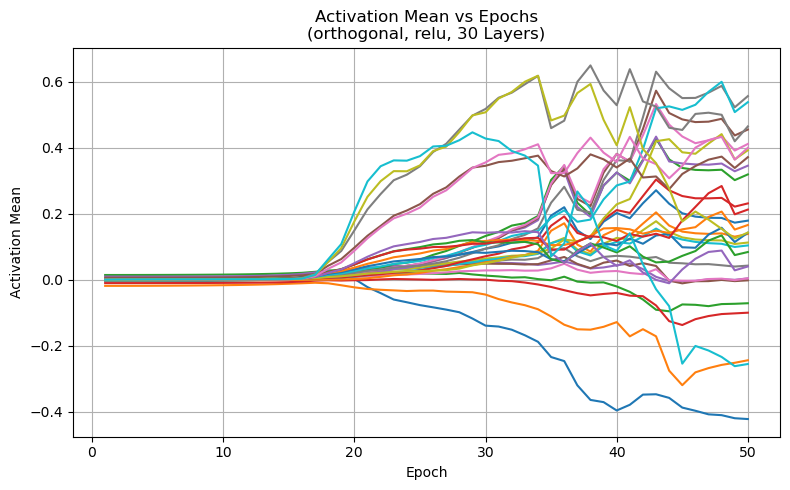

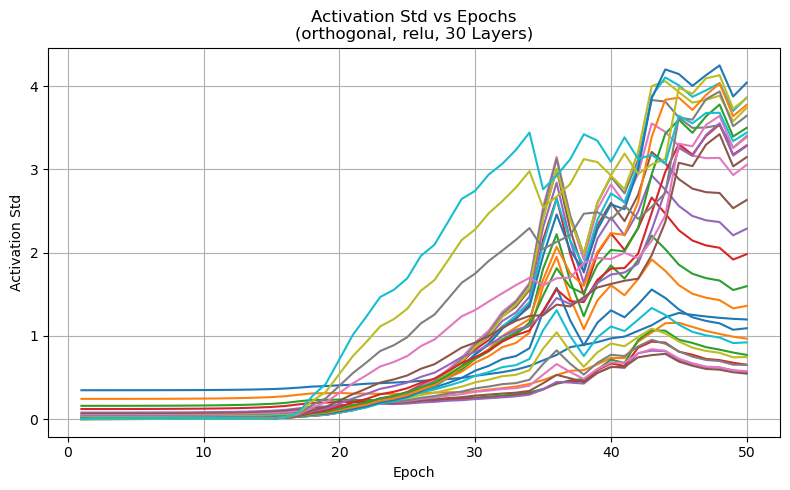

In [6]:
# Activation Mean and Std Visualization
import pandas as pd
import matplotlib.pyplot as plt
import os

# ✅ Manually specify parameters
DATA_DIR = "results"         # Directory where your CSV files are stored
init_type = "orthogonal"     # Initialization method
activation = "relu"          # Activation function
layer_list = [40, 30]        # Target layer counts

for num_layers in layer_list:
    csv_path = os.path.join(DATA_DIR, f"{init_type}_{activation}_{num_layers}L.csv")
    
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"File not found: {csv_path}")
    
    df = pd.read_csv(csv_path)
    
    # Automatically find all activation mean and std columns
    act_mean_cols = [col for col in df.columns if col.startswith("act_mean_")]
    act_std_cols = [col for col in df.columns if col.startswith("act_std_")]
    epochs = range(1, len(df) + 1)

    # Plot Activation Mean
    plt.figure(figsize=(8, 5))
    for col in act_mean_cols:
        layer_idx = col.split("_")[-1]
        plt.plot(epochs, df[col], label=f"Layer {layer_idx}")
    plt.title(f"Activation Mean vs Epochs\n({init_type}, {activation}, {num_layers} Layers)")
    plt.xlabel("Epoch")
    plt.ylabel("Activation Mean")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot Activation Std
    plt.figure(figsize=(8, 5))
    for col in act_std_cols:
        layer_idx = col.split("_")[-1]
        plt.plot(epochs, df[col], label=f"Layer {layer_idx}")
    plt.title(f"Activation Std vs Epochs\n({init_type}, {activation}, {num_layers} Layers)")
    plt.xlabel("Epoch")
    plt.ylabel("Activation Std")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Gradient Norm Visualization

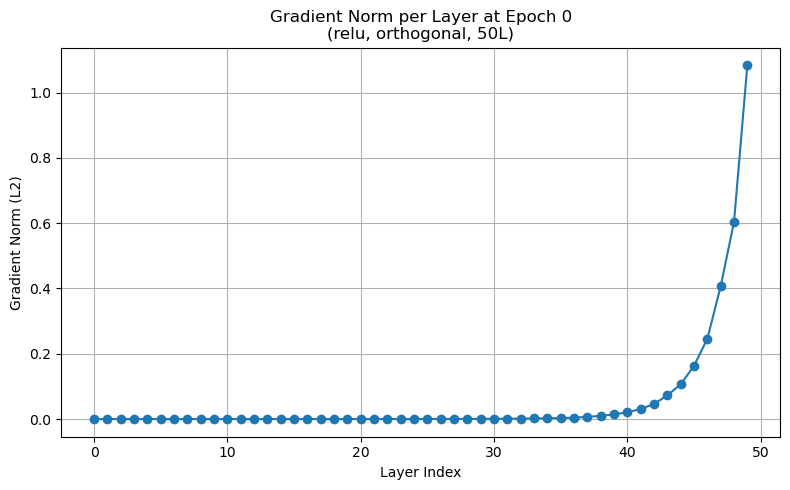

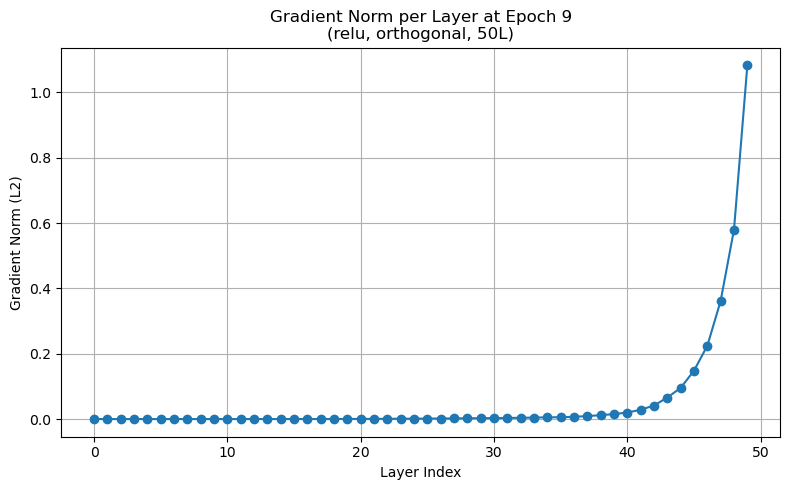

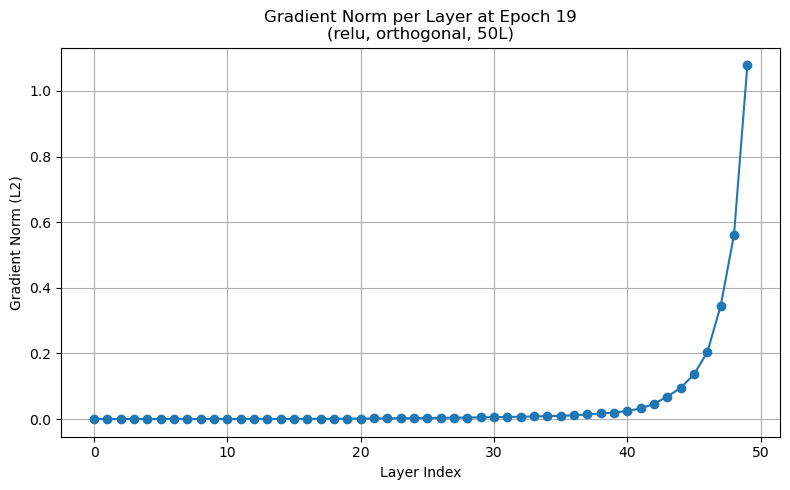

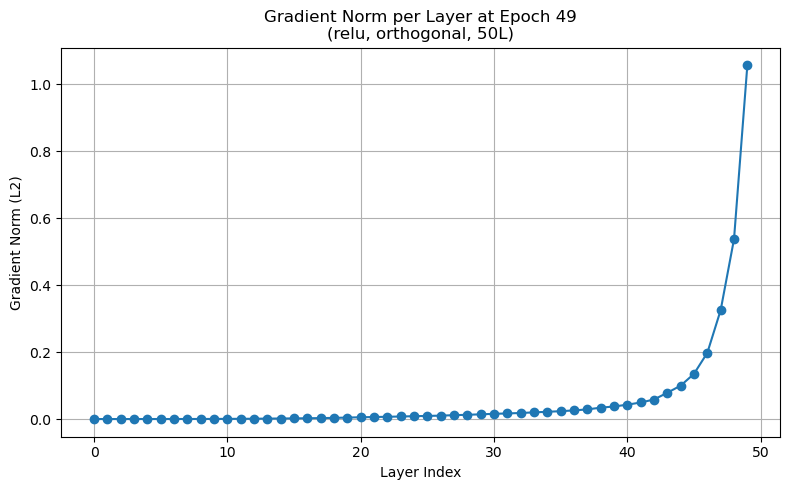

In [7]:
# Gradient Norm Visualization

import pandas as pd
import matplotlib.pyplot as plt
import os

# Parameters
DATA_DIR = "results"
init = "orthogonal"
activation = "relu"
num_layers = 50
csv_path = os.path.join(DATA_DIR, f"{init}_{activation}_{num_layers}L.csv")
target_epochs = [0, 9, 19, 49]  # Note: Index starts from 0

# Load CSV data
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"File not found: {csv_path}")
df = pd.read_csv(csv_path)

# Automatically identify all grad_norm_* columns
grad_cols = [col for col in df.columns if col.startswith("grad_norm_")]
layer_indices = [int(col.split("_")[-1]) for col in grad_cols]
layer_indices.sort()

# Plot gradient norm for selected epochs
for ep in target_epochs:
    if ep >= len(df):
        print(f"⚠️ Epoch {ep} exceeds CSV length, skipping")
        continue

    grads = [df.loc[ep, f"grad_norm_{i}"] for i in layer_indices]
    plt.figure(figsize=(8, 5))
    plt.plot(layer_indices, grads, marker='o')
    plt.title(f"Gradient Norm per Layer at Epoch {ep}\n({activation}, {init}, {num_layers}L)")
    plt.xlabel("Layer Index")
    plt.ylabel("Gradient Norm (L2)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Accuracy Generalization Comparison Across Different Layer Depths

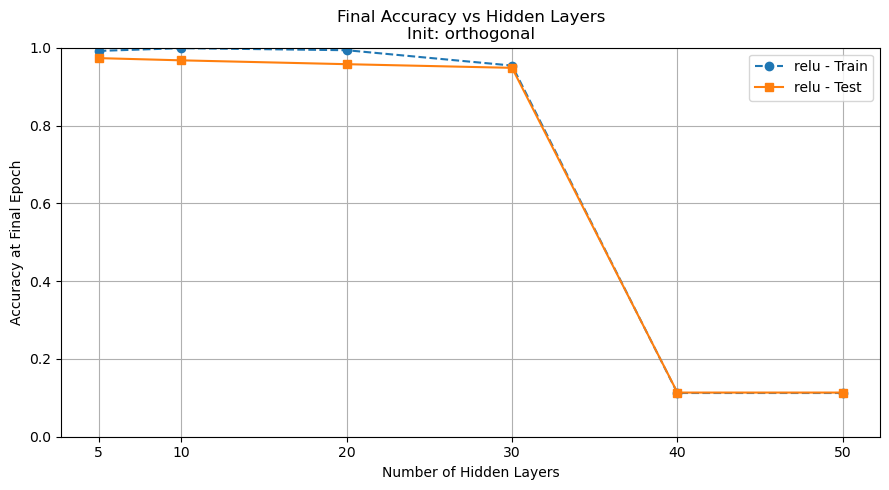

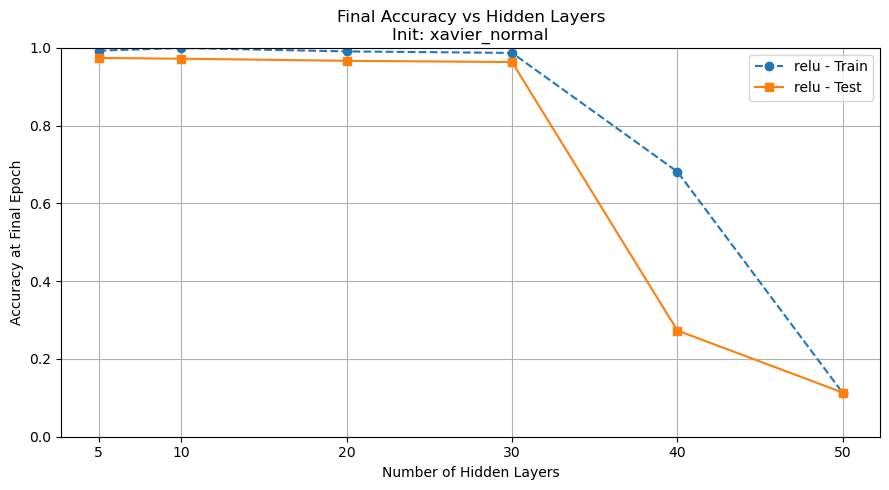

In [8]:
# Accuracy Generalization Comparison Across Different Layer Depths

import pandas as pd
import matplotlib.pyplot as plt
import os

# Parameters
DATA_DIR = "results"
init_types = ["orthogonal", "xavier_normal"]
activations = ["relu"]  # Optionally include: "sigmoid", "tanh", "gelu"
layers_list = [5, 10, 20, 30, 40, 50]

# Main function
def plot_by_init_separately():
    for init in init_types:
        plt.figure(figsize=(9, 5))
        for act in activations:
            train_accs, test_accs, valid_layers = [], [], []
            for nl in layers_list:
                path = os.path.join(DATA_DIR, f"{init}_{act}_{nl}L.csv")
                if not os.path.exists(path):
                    print(f"⚠️ Missing file: {path}")
                    continue
                df = pd.read_csv(path)
                if 'train_acc' not in df.columns or 'test_acc' not in df.columns:
                    print(f"⚠️ Missing train/test_acc columns in: {path}")
                    continue
                train_accs.append(df['train_acc'].iloc[-1])
                test_accs.append(df['test_acc'].iloc[-1])
                valid_layers.append(nl)
            # Plot for each activation function
            if train_accs:
                plt.plot(valid_layers, train_accs, marker='o', linestyle='--', label=f"{act} - Train")
                plt.plot(valid_layers, test_accs, marker='s', linestyle='-', label=f"{act} - Test")

        # Plot style
        plt.title(f"Final Accuracy vs Hidden Layers\nInit: {init}")
        plt.xlabel("Number of Hidden Layers")
        plt.ylabel("Accuracy at Final Epoch")
        plt.ylim(0, 1.0)
        plt.xticks(layers_list)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

# Run
plot_by_init_separately()

## 📎 Appendix: NumPy Implementation (Using `courselib`)

The following is the NumPy-based implementation integrated with `courselib`,  
kept for verification and educational reference. This version is not used in the full-scale experiments due to its slower runtime.

In [9]:
# deepmlp_numpy.py
import numpy as np
import os
import time
import pandas as pd
from typing import Dict
from courselib.models.nn import DenseLayer, ReLU, Sigmoid, Linear, Softmax, CrossEntropy
from courselib.optimizers import GDOptimizer
from courselib.models.base import TrainableModel
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

# ==================== Configuration Parameters ====================
CONFIG = {
    "layers_list": [5, 10, 20, 30, 40, 50],
    "init_types": [
        "he_normal", "he_uniform",
        "xavier_normal", "xavier_uniform",
        "normal", "zero",
        "orthogonal", "trunc_normal"
    ],
    "activations": ["ReLU", "Sigmoid"],
    "init_params": {
        "he_normal":   {"factor": 2.0, "mode": "fan_in"},
        "he_uniform":  {"factor": 2.0, "mode": "fan_in"},
        "orthogonal":  {"gain": 1.0},
        "trunc_normal": {"mean": 0.0, "std": 0.01, "a": -2.0, "b": 2.0}
    },
    "hidden_size": 128,
    "input_size": 784,
    "output_size": 10,
    "num_epochs": 50,
    "lr": 0.01,
    "batch_size": 128,
    "save_dir": "results_numpy"
}

# ==================== Weight Initialization ====================
def initialize_weights(model, init_type: str, params: Dict):
    """
    Initialize model parameters according to the specified initialization type and parameters.
    """
    for key, value in model.params.items():
        if key.endswith('_W'):
            shape = value.shape
            if init_type == "he_normal":
                fan_in = shape[0]
                std = np.sqrt(params.get("factor", 2.0) / fan_in)
                model.params[key] = np.random.randn(*shape) * std
            elif init_type == "he_uniform":
                fan_in = shape[0]
                bound = np.sqrt(3.0 * params.get("factor", 2.0) / fan_in)
                model.params[key] = np.random.uniform(-bound, bound, size=shape)
            elif init_type == "xavier_normal":
                fan_in, fan_out = shape
                std = np.sqrt(2.0 / (fan_in + fan_out))
                model.params[key] = np.random.randn(*shape) * std
            elif init_type == "xavier_uniform":
                fan_in, fan_out = shape
                bound = np.sqrt(6.0 / (fan_in + fan_out))
                model.params[key] = np.random.uniform(-bound, bound, size=shape)
            elif init_type == "normal":
                mean = params.get("mean", 0.0)
                std = params.get("std", 0.01)
                model.params[key] = np.random.normal(mean, std, size=shape)
            elif init_type == "zero":
                model.params[key] = np.zeros(shape)
        elif key.endswith('_b'):
            model.params[key] = np.zeros_like(value)

# ==================== Data Loading ====================
def get_dataloaders(batch_size: int):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))
    ])
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

    def to_numpy_loader(dataset):
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        for x, y in loader:
            yield x.numpy(), np.eye(CONFIG['output_size'])[y.numpy()]

    return to_numpy_loader(train_dataset), to_numpy_loader(test_dataset)

# ==================== Model Definition ====================
class DeepMLP(TrainableModel):
    def __init__(
        self, input_size: int, hidden_size: int, output_size: int,
        num_hidden_layers: int, activation: str, optimizer
    ):
        super().__init__(optimizer)
        self.layers = []
        self.params = {}
        self.grads = {}
        self._inputs = []  # Cache inputs for each layer
        self._zs = []      # Cache pre-activations for each layer

        # Construct hidden layers
        for i in range(num_hidden_layers):
            in_size = input_size if i == 0 else hidden_size
            layer = DenseLayer(in_size, hidden_size, activation=activation, layer_name=f"L{i}")
            self.layers.append(layer)
            for k, v in layer._get_params().items():
                self.params[k] = v
                self.grads[k] = np.zeros_like(v)

        # Construct output layer (Linear + Softmax)
        out_layer = DenseLayer(hidden_size, output_size, activation='Linear', layer_name="Out")
        self.layers.append(out_layer)
        for k, v in out_layer._get_params().items():
            self.params[k] = v
            self.grads[k] = np.zeros_like(v)

        self.loss_fn = CrossEntropy()
        self.softmax = Softmax()

    def forward(self, X: np.ndarray, training: bool=False) -> np.ndarray:
        """
        Perform forward propagation through all layers and return softmax output.
        """
        self._inputs = []
        self._zs = []
        out = X
        for layer in self.layers:
            self._inputs.append(out)
            z, out = layer(out)
            self._zs.append(z)
        return self.softmax(out)

    def loss(self, Y_pred: np.ndarray, Y_true: np.ndarray) -> float:
        """
        Compute the loss between predictions and true labels.
        """
        return self.loss_fn(Y_pred, Y_true)

    def backward(self, X: np.ndarray, Y_pred: np.ndarray, Y_true: np.ndarray):
        """
        Perform backward propagation: compute gradients for each layer.
        """
        delta = self.loss_fn.grad(Y_pred, Y_true)  # Initial gradient from softmax+crossentropy
        for idx in reversed(range(len(self.layers))):
            layer = self.layers[idx]
            prev_out = self._inputs[idx]
            grads = layer.loss_grad(prev_out, delta)
            for k, g in grads.items():
                self.grads[k] = g
            if idx > 0:
                W_next = layer.W
                z_prev = self._zs[idx-1]
                delta = self.layers[idx-1].compute_delta(z_prev, W_next, delta)

# ==================== Training and Evaluation ====================
def train(model: DeepMLP, optimizer: GDOptimizer, loader) -> tuple:
    total_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        y_pred = model.forward(x)
        loss = model.loss(y_pred, y)
        model.backward(x, y_pred, y)
        optimizer.update(model.params, model.grads)
        total_loss += loss * x.shape[0]
        correct += (np.argmax(y_pred, axis=1) == np.argmax(y, axis=1)).sum()
        total += x.shape[0]
    return total_loss / total, correct / total

def evaluate(model: DeepMLP, loader) -> tuple:
    total_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        y_pred = model.forward(x)
        loss = model.loss(y_pred, y)
        total_loss += loss * x.shape[0]
        correct += (np.argmax(y_pred, axis=1) == np.argmax(y, axis=1)).sum()
        total += x.shape[0]
    return total_loss / total, correct / total

# ==================== Experiment Workflow ====================
def run_experiment(init_type: str, num_layers: int, activation: str, config: Dict) -> Dict:
    """
    Run a single experiment: initialize model, train, evaluate, and record stats.
    """
    train_loader, test_loader = get_dataloaders(config['batch_size'])
    optimizer = GDOptimizer(learning_rate=config['lr'])
    model = DeepMLP(
        config['input_size'], config['hidden_size'], config['output_size'],
        num_layers, activation, optimizer
    )
    initialize_weights(model, init_type, config.get('init_params', {}).get(init_type, {}))

    # Prepare history dictionary with basic metrics and per-layer stats
    history = {
        'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': [], 'epoch_time': []
    }
    num_hidden = len(model.layers) - 1
    for i in range(num_hidden):
        history[f'act_mean_{i}'] = []
        history[f'act_std_{i}']  = []
        history[f'grad_norm_{i}'] = []

    prefix = f"{init_type}_{activation}_{num_layers}L"
    os.makedirs(config['save_dir'], exist_ok=True)

    for ep in range(1, config['num_epochs'] + 1):
        # Reinitialize data loaders each epoch to avoid exhaustion
        train_loader, test_loader = get_dataloaders(config['batch_size'])

        start = time.time()
        tl, ta = train(model, optimizer, train_loader)
        vl, va = evaluate(model, test_loader)
        duration = time.time() - start

        # Record basic metrics
        history['train_loss'].append(tl)
        history['test_loss'].append(vl)
        history['train_acc'].append(ta)
        history['test_acc'].append(va)
        history['epoch_time'].append(duration)

        # Record per-layer activation and gradient statistics
        for i in range(num_hidden):
            z = model._zs[i]
            history[f'act_mean_{i}'].append(z.mean())
            history[f'act_std_{i}'].append(z.std())
            grad = model.grads[f"L{i}_W"]
            history[f'grad_norm_{i}'].append(np.linalg.norm(grad))

        print(f"[{init_type}|{activation}|{num_layers}L] "
              f"Epoch {ep}/{config['num_epochs']} "
              f"TrainLoss={tl:.4f} TrainAcc={ta:.4f} "
              f"TestLoss={vl:.4f} TestAcc={va:.4f} "
              f"Time={duration:.2f}s")

    # Save history to CSV
    df = pd.DataFrame(history)
    df.to_csv(os.path.join(config['save_dir'], f"{prefix}.csv"), index=False)
    return history


if __name__ == '__main__':
    os.makedirs(CONFIG['save_dir'], exist_ok=True)
    total_exps = len(CONFIG['init_types']) * len(CONFIG['activations']) * len(CONFIG['layers_list'])
    completed = 0
    overall_start = time.time()

    for init in CONFIG['init_types']:
        for act in CONFIG['activations']:
            for layers in CONFIG['layers_list']:
                run_experiment(init, layers, act, CONFIG)
                completed += 1
                elapsed = time.time() - overall_start
                avg = elapsed / completed
                eta = avg * (total_exps - completed)
                print(f"[{completed}/{total_exps}] Elapsed={time.strftime('%H:%M:%S', time.gmtime(elapsed))} "
                      f"ETA={time.strftime('%H:%M:%S', time.gmtime(eta))}")

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

[he_normal|ReLU|5L] Epoch 1/50 TrainLoss=2.3588 TrainAcc=0.0834 TestLoss=2.3634 TestAcc=0.0854 Time=29.68s


KeyboardInterrupt: 